In [2]:
import json
import os
import numpy
import pandas
import copy
import conntility, connalysis

from scipy.spatial import distance
from pnagm import util, nngraph, instance, test

from matplotlib import pyplot as plt



In [2]:
config_fn = "../configs/characterization_recursive.json"
plot_out = "plots_r"

with open(config_fn, "r") as fid:
    cfg = json.load(fid)

pts = util.make_points(cfg["make_points"])
pts_df = pandas.DataFrame(pts, columns=["x", "y", "z"])

if not os.path.exists(plot_out):
    os.makedirs(plot_out)

In [4]:
M = nngraph.cand2_point_nn_matrix(pts, **cfg["nngraph"])

mdls = []
conmats = []
for _ in range(3):
    cfg["instance"]["step_tgt"] = cfg["instance"]["step_tgt"] * 1.1
    mdl, dbug1, dbug2 = instance.build_instance(pts, M, **cfg["instance"])
    M = mdl
    mdls.append(mdl)
    conmats.append(conntility.ConnectivityMatrix(mdl, vertex_properties=pts_df))
conmats = conntility.ConnectivityGroup(pandas.DataFrame({"iteration": range(len(conmats))}),
                                       conmats)

In [4]:
def degree_distr(m, pts):
    m = m.tocoo()
    outdeg = pandas.Series(m.row).value_counts().value_counts()
    outdeg = outdeg.reindex(range(1, outdeg.index.max() + 1))
    indeg = pandas.Series(m.col).value_counts().value_counts()
    indeg = indeg.reindex(range(1, indeg.index.max() + 1))
    outdeg.name = "outdeg"; indeg.name = "indeg"
    degs = pandas.concat([outdeg, indeg], axis=1)
    return degs

def degrees(m, pts):
    m = m.tocoo()
    outdeg = pandas.Series(m.row).value_counts()
    #outdeg = outdeg.reindex(range(len(pts)), fill_value=0)
    indeg = pandas.Series(m.col).value_counts()
    #indeg = indeg.reindex(range(len(pts)), fill_value=0)
    outdeg.name = "outdeg"; indeg.name = "indeg"
    degs = pandas.concat([outdeg, indeg], axis=1)
    return degs

deg_analysis = {
    "analyses": {
        "degrees":{
            "source": degrees,
            "output": "DataFrame"
        }
    }
}
deg_results = conmats.analyze(deg_analysis)["degrees"]

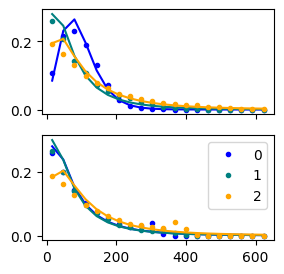

In [6]:
from scipy import stats

logbins = numpy.logspace(0, numpy.log10(numpy.percentile(deg_results, 100)), 21)
logbins = numpy.linspace(0, numpy.max(deg_results), 21)
bin_centers = 0.5 * (logbins[:-1] + logbins[1:])

h_func = lambda _x: pandas.Series(
    numpy.histogram(_x, bins=logbins)[0] / len(_x),
    index=bin_centers
)

def fit_lognorm_to_degrees(degs):
    distr = stats.lognorm.fit(degs.dropna().values)
    return distr

data_hists = deg_results.unstack("iteration").apply(h_func, axis=0)
fit_distrs = deg_results.unstack("iteration").apply(fit_lognorm_to_degrees, axis=0)

fig = plt.figure(figsize=(3, 3))
axes = fig.subplots(2, 1, sharex=True)
cols = {
    0: "blue", 1: "teal", 2: "orange"
}

for col, ax in zip(["indeg", "outdeg"], axes):
    pltme = data_hists[col]
    fitme = fit_distrs[col]
    for iteration in pltme.columns:
        ax.plot(pltme[iteration], marker="o", ms=3, ls="None", label=iteration, color=cols[iteration])
        fit_res = stats.lognorm(*fitme[iteration]).pdf(pltme.index)
        fit_res = fit_res / fit_res.sum()
        ax.plot(pltme.index, fit_res, color=cols[iteration])
    #ax.set_yscale("log")
plt.legend()

In [7]:
D = distance.squareform(distance.pdist(pts))
dbins = numpy.linspace(0, 2500, 41)
dbins[0] = 1E-5

dbin_c = 0.5 * (numpy.array(dbins[:-1]) + numpy.array(dbins[1:]))
Db = numpy.digitize(D, bins=dbins) - 1


def build_dd_info_df(mdl_instance):
    mdl_arr = numpy.array(mdl_instance.todense())
    df = pandas.DataFrame({
                           "con": mdl_arr.flatten(), "dbin": Db.flatten()
                           })
    df = df[df["dbin"] >= 0]
    df = df[df["dbin"] < len(dbin_c)]
    df["distance"] = dbin_c[df["dbin"]]
    return df

df = pandas.concat([build_dd_info_df(_instance) for _instance in mdls],
                   axis=0, keys=conmats.index)
pltme = df.groupby(["iteration", "distance"])["con"].mean().unstack("iteration")

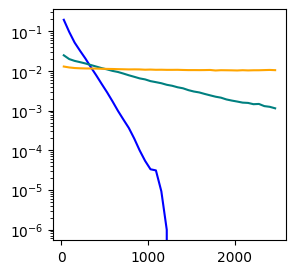

In [8]:
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

for iteration in pltme.columns:
    ax.plot(pltme[iteration], color=cols[iteration])
plt.gca().set_yscale("log")

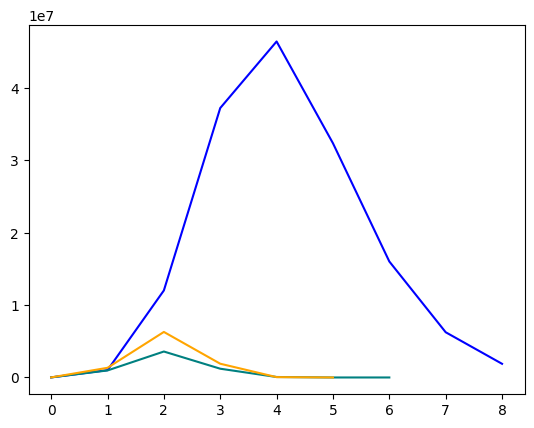

In [9]:
for iteration in range(len(mdls)):
    c = cols[iteration]
    plt.plot(connalysis.network.topology.simplex_counts(mdls[iteration], max_dim=8),
             color=c)

In [38]:
pts = util.make_points({'n_nrn': 11000, 'tgt_sz': [400, 2000, 400]})
pts_df = pandas.DataFrame(pts, columns=["x", "y", "z"])

mdls = []
conmats = []
M = nngraph.cand2_point_nn_matrix(pts, n_neighbors=4, n_pick=4)

mdl, _, _ = instance.build_instance(pts, M, n_steps=100, step_tgt=1.1, n_protected=3)
conmats.append(conntility.ConnectivityMatrix(mdl, vertex_properties=pts_df))
mdls.append(mdl)
mdl, _, _ = instance.build_instance(pts, mdl, n_steps=100, step_tgt=1.5, n_protected=3)
conmats.append(conntility.ConnectivityMatrix(mdl, vertex_properties=pts_df))
mdls.append(mdl)
mdl, _, _ = instance.build_instance(pts, mdl, n_steps=100, step_tgt=1.9, n_protected=3)
conmats.append(conntility.ConnectivityMatrix(mdl, vertex_properties=pts_df))
mdls.append(mdl)
mdl, _, _ = instance.build_instance(pts, mdl, n_steps=100, step_tgt=2.3, n_protected=3)
conmats.append(conntility.ConnectivityMatrix(mdl, vertex_properties=pts_df))
mdls.append(mdl)
mdl, _, _ = instance.build_instance(pts, mdl, n_steps=100, step_tgt=2.7, n_protected=3)
conmats.append(conntility.ConnectivityMatrix(mdl, vertex_properties=pts_df))
mdls.append(mdl)
mdl, _, _ = instance.build_instance(pts, mdl, n_steps=100, step_tgt=3.1, n_protected=3)
conmats.append(conntility.ConnectivityMatrix(mdl, vertex_properties=pts_df))
mdls.append(mdl)

conmats = conntility.ConnectivityGroup(pandas.DataFrame({"iteration": range(len(conmats))}),
                                       conmats)

/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: 

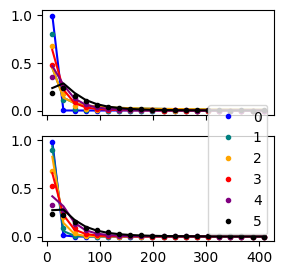

In [39]:
deg_results = conmats.analyze(deg_analysis)["degrees"]

from scipy import stats

logbins = numpy.logspace(0, numpy.log10(numpy.percentile(deg_results, 100)), 21)
logbins = numpy.linspace(0, numpy.max(deg_results), 21)
bin_centers = 0.5 * (logbins[:-1] + logbins[1:])

h_func = lambda _x: pandas.Series(
    numpy.histogram(_x, bins=logbins)[0] / len(_x),
    index=bin_centers
)

def fit_lognorm_to_degrees(degs):
    distr = stats.lognorm.fit(degs.dropna().values)
    return distr

data_hists = deg_results.unstack("iteration").apply(h_func, axis=0)
fit_distrs = deg_results.unstack("iteration").apply(fit_lognorm_to_degrees, axis=0)

fig = plt.figure(figsize=(3, 3))
axes = fig.subplots(2, 1, sharex=True)
cols = {
    0: "blue", 1: "teal", 2: "orange", 3: "red", 4: "purple", 5: "black"
}

for col, ax in zip(["indeg", "outdeg"], axes):
    pltme = data_hists[col]
    fitme = fit_distrs[col]
    for iteration in pltme.columns:
        ax.plot(pltme[iteration], marker="o", ms=3, ls="None", label=iteration, color=cols[iteration])
        fit_res = stats.lognorm(*fitme[iteration]).pdf(pltme.index)
        fit_res = fit_res / fit_res.sum()
        ax.plot(pltme.index, fit_res, color=cols[iteration])
    # ax.set_yscale("log")
    # ax.set_ylim([1E-6, 1])
plt.legend()

In [40]:
D = distance.squareform(distance.pdist(pts))
dbins = numpy.linspace(0, 2500, 41)
dbins[0] = 1E-5

dbin_c = 0.5 * (numpy.array(dbins[:-1]) + numpy.array(dbins[1:]))
Db = numpy.digitize(D, bins=dbins) - 1


def build_dd_info_df(mdl_instance):
    mdl_arr = numpy.array(mdl_instance.todense())
    df = pandas.DataFrame({
                           "con": mdl_arr.flatten(), "dbin": Db.flatten()
                           })
    df = df[df["dbin"] >= 0]
    df = df[df["dbin"] < len(dbin_c)]
    df["distance"] = dbin_c[df["dbin"]]
    return df

df = pandas.concat([build_dd_info_df(_instance) for _instance in mdls],
                   axis=0, keys=conmats.index)
pltme = df.groupby(["iteration", "distance"])["con"].mean().unstack("iteration")

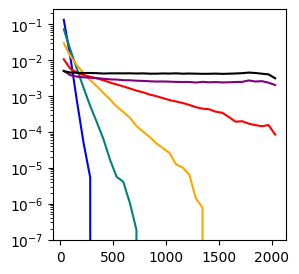

In [41]:
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

for iteration in pltme.columns:
    ax.plot(pltme[iteration], color=cols[iteration])
plt.gca().set_yscale("log")

0
1
2
3
4
5


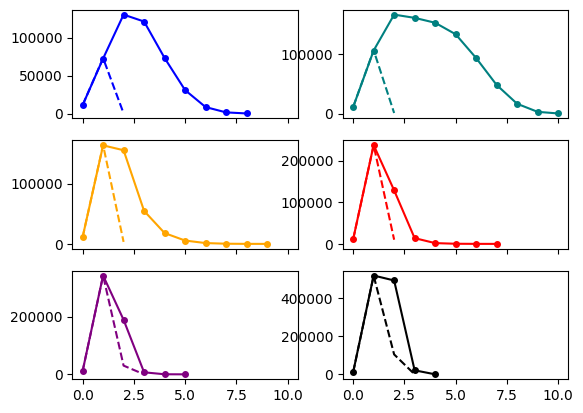

In [43]:
fig = plt.figure()
axes = fig.subplots(3, 2, sharex=True).flatten()

for iteration in range(len(conmats.index)):
    print(iteration)
    ax = axes[0]
    axes = axes[1:]
    m = conmats[iteration].matrix
    er = connalysis.randomization.ER_model(m)
    s_counts = connalysis.network.topology.simplex_counts(m, max_dim=11)
    er_counts = connalysis.network.topology.simplex_counts(er, max_dim=11)
    ax.plot(s_counts, color=cols[iteration], marker="o", ms=4)
    ax.plot(er_counts, color=cols[iteration], ls="--")

In [32]:
def random_subsample(mdl, n_pick):
    from scipy import sparse
    mdl = mdl.tocoo()
    m_df = pandas.DataFrame({
        "row": mdl.row,
        "col": mdl.col
    })

    m_out = m_df.groupby("row")["col"].apply(lambda _x: numpy.random.choice(_x, numpy.minimum(n_pick, len(_x)), replace=False))
    m_out = m_out.reindex(range(mdl.shape[0]), fill_value=[])
    indptr = numpy.cumsum([0] + list(m_out.apply(len)))
    indices = numpy.hstack(m_out.values)

    return sparse.csr_matrix((numpy.ones(len(indices), dtype=bool),
                    indices,
                    indptr),
                    shape=mdl.shape)

In [33]:
pts = util.make_points({'n_nrn': 11000, 'tgt_sz': [400, 2000, 400]})
pts_df = pandas.DataFrame(pts, columns=["x", "y", "z"])

mdls = []
conmats = []
M = nngraph.cand2_point_nn_matrix(pts, n_neighbors=4, n_pick=4)

for _ in range(6):
    mdl, _, _ = instance.build_instance(pts, M, n_steps=100, step_tgt=2.5, n_protected=3)
    conmats.append(conntility.ConnectivityMatrix(mdl, vertex_properties=pts_df))
    mdls.append(mdl)
    mdl = mdl.tocoo()
    M = random_subsample(mdl, 10)
    
conmats = conntility.ConnectivityGroup(pandas.DataFrame({"iteration": range(len(conmats))}),
                                       conmats)

/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: RuntimeWarning: invalid value encountered in divide
  p = p_mat.data[a:b] / p_mat.data[a:b].sum()
/Users/mwr/Documents/repositories/local_connectivity_model/src/pnagm/instance.py:16: 

In this notebook I characterize what happens if you build a stochastic spread graph on a stochastic spread graph.
This did not make it into the manuscript yet.

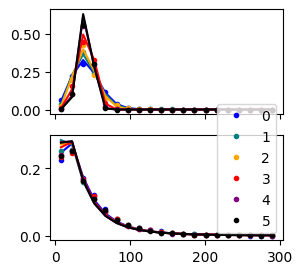

In [34]:
deg_results = conmats.analyze(deg_analysis)["degrees"]

from scipy import stats

logbins = numpy.logspace(0, numpy.log10(numpy.percentile(deg_results, 100)), 21)
logbins = numpy.linspace(0, numpy.max(deg_results), 21)
bin_centers = 0.5 * (logbins[:-1] + logbins[1:])

h_func = lambda _x: pandas.Series(
    numpy.histogram(_x, bins=logbins)[0] / len(_x),
    index=bin_centers
)

def fit_lognorm_to_degrees(degs):
    distr = stats.lognorm.fit(degs.dropna().values)
    return distr

data_hists = deg_results.unstack("iteration").apply(h_func, axis=0)
fit_distrs = deg_results.unstack("iteration").apply(fit_lognorm_to_degrees, axis=0)

fig = plt.figure(figsize=(3, 3))
axes = fig.subplots(2, 1, sharex=True)
cols = {
    0: "blue", 1: "teal", 2: "orange", 3: "red", 4: "purple", 5: "black"
}

for col, ax in zip(["indeg", "outdeg"], axes):
    pltme = data_hists[col]
    fitme = fit_distrs[col]
    for iteration in pltme.columns:
        ax.plot(pltme[iteration], marker="o", ms=3, ls="None", label=iteration, color=cols[iteration])
        fit_res = stats.lognorm(*fitme[iteration]).pdf(pltme.index)
        fit_res = fit_res / fit_res.sum()
        ax.plot(pltme.index, fit_res, color=cols[iteration])
    # ax.set_yscale("log")
    # ax.set_ylim([1E-6, 1])
plt.legend()

In [35]:
D = distance.squareform(distance.pdist(pts))
dbins = numpy.linspace(0, 2500, 41)
dbins[0] = 1E-5

dbin_c = 0.5 * (numpy.array(dbins[:-1]) + numpy.array(dbins[1:]))
Db = numpy.digitize(D, bins=dbins) - 1


def build_dd_info_df(mdl_instance):
    mdl_arr = numpy.array(mdl_instance.todense())
    df = pandas.DataFrame({
                           "con": mdl_arr.flatten(), "dbin": Db.flatten()
                           })
    df = df[df["dbin"] >= 0]
    df = df[df["dbin"] < len(dbin_c)]
    df["distance"] = dbin_c[df["dbin"]]
    return df

df = pandas.concat([build_dd_info_df(_instance) for _instance in mdls],
                   axis=0, keys=conmats.index)
pltme = df.groupby(["iteration", "distance"])["con"].mean().unstack("iteration")

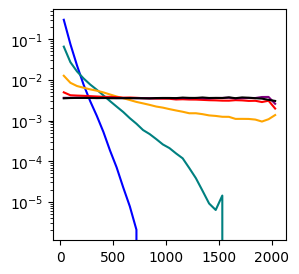

In [36]:
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

for iteration in pltme.columns:
    ax.plot(pltme[iteration], color=cols[iteration])
plt.gca().set_yscale("log")

0
1
2
3
4
5


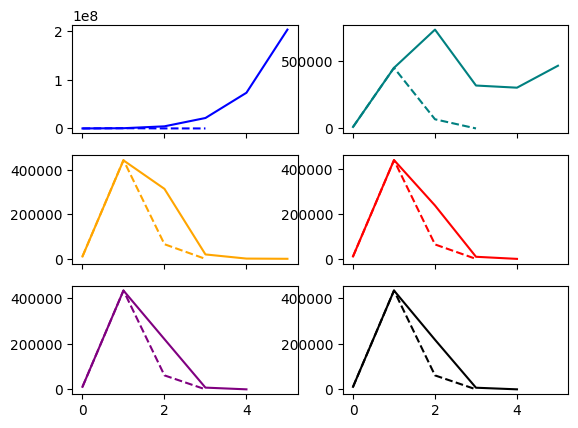

In [37]:
fig = plt.figure()
axes = fig.subplots(3, 2, sharex=True).flatten()

for iteration in range(len(conmats.index)):
    print(iteration)
    ax = axes[0]
    axes = axes[1:]
    m = conmats[iteration].matrix
    er = connalysis.randomization.ER_model(m)
    s_counts = connalysis.network.topology.simplex_counts(m, max_dim=5)
    er_counts = connalysis.network.topology.simplex_counts(er, max_dim=5)
    ax.plot(s_counts, color=cols[iteration])
    ax.plot(er_counts, color=cols[iteration], ls="--")